In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = pd.to_datetime(latest_date)

start_date = (latest_date - dt.timedelta(days=365)).to_pydatetime()[0]

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(session.query(measurement.date, measurement.prcp).filter(measurement.date > start_date).all())

# Sort the dataframe by date
df = df.sort_values('date')
df.set_index('date',inplace=True)


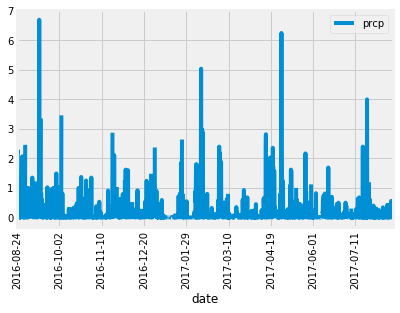

In [12]:

fig = df.plot(rot=90).get_figure()
fig.savefig('precipitation.png')


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(measurement.station).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).first()[0]

highest = session.query(func.max(measurement.tobs)).filter(measurement.station == station_id).scalar()
lowest = session.query(func.min(measurement.tobs)).filter(measurement.station == station_id).scalar()

print(f"The most active station in the dataset is: {station_id}.")
print(f"Highest recorded temperature for {station_id} is {highest}.")
print(f"Lowest recorded temperature for {station_id} is {lowest}.")   

The most active station in the dataset is: USC00519281.
Highest recorded temperature for USC00519281 is 85.0.
Lowest recorded temperature for USC00519281 is 54.0.


The station with the highest number of temparature observations in the last year is: USC00519397.


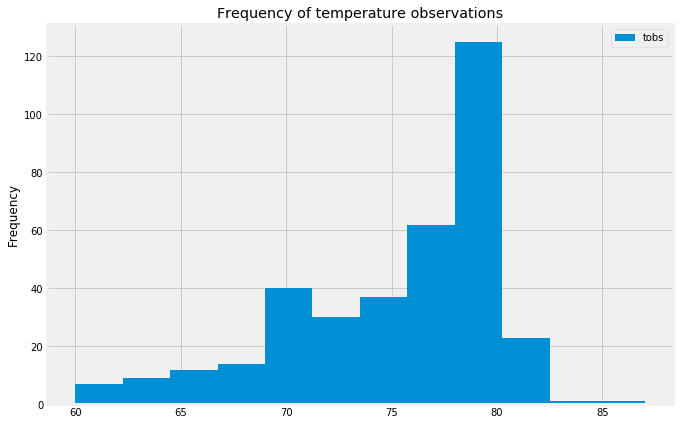

In [87]:
# Choose the station with the highest number of temperature observations in the last 12 months

station_id = session.query(measurement.station, func.count(measurement.station)).\
filter(measurement.date > start_date).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).first()[0]

print(f"The station with the highest number of temparature observations in the last year is: {station_id}.")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df = pd.DataFrame(session.query(measurement.tobs).\
                  filter(measurement.station == station_id).\
                  filter(measurement.date >= start_date.date()).\
                  filter(measurement.date <= latest_date[0].date()).all())

ax = df.plot(kind='hist', bins=12, figsize=(10,7))
ax.set_title("Frequency of temperature observations")
ax.set_ylabel("Frequency")
plt.savefig("station-histogram.png")
plt.show()



## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [133]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-04-10'
trip_end = '2017-04-24'

# # User previous year's data for the same dates
prev_year_start = dt.date(2017,4,10) - dt.timedelta(days=365)
prev_year_end = dt.date(2017,4,24) - dt.timedelta(days=365)

trip_data = calc_temps(prev_year_start, prev_year_end)

print(trip_data)

[(66.0, 73.64516129032258, 80.0)]


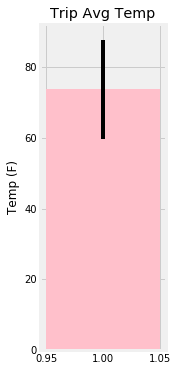

In [134]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Tmin = trip_data[0][0]
Tavg = trip_data[0][1]
Tmax = trip_data[0][2]

x = np.arange(1,2)

plt.figure(figsize=(2,6))
plt.bar(x,Tavg, 0.1, linewidth = 10, color="pink", yerr=Tmax-Tmin)

plt.title("Trip Avg Temp")

plt.ylabel("Temp (F)")
plt.savefig("Temperature.png")
plt.show()



In [135]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)).\
filter(measurement.date >= prev_year_start).filter(measurement.date <= prev_year_end).\
filter(measurement.station == station.station).\
group_by(measurement.station).\
order_by(func.sum(measurement.prcp).desc()).all()



[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 11.03),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.33),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.1900000000000002),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.1800000000000002),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.8),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.43999999999999995),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [136]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
#daily_normals("01-01")

In [137]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
trip_start = '2017-04-10'
trip_end = '2017-04-24'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# push each tuple of calculations into a list called `normals`
normals = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0)]

In [138]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head(15)

,tmin,tavg,tmax
date,,,
2017-04-10,64.0,71.403509,79.0
2017-04-11,65.0,72.491803,82.0
2017-04-12,65.0,72.224138,80.0
2017-04-13,64.0,71.525424,79.0
2017-04-14,65.0,72.750000,81.0
2017-04-15,61.0,71.793103,79.0
2017-04-16,62.0,71.553571,81.0
2017-04-17,65.0,71.931034,77.0
2017-04-18,67.0,72.491525,77.0


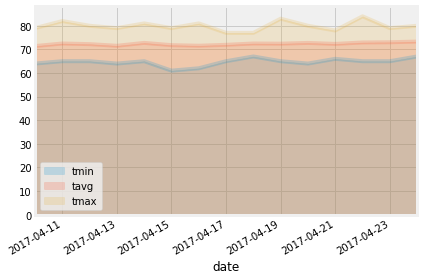

In [139]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()

plt.savefig("daily-normals.png")

plt.show()